In [1]:
import tensorflow as tf
from tensorflow.contrib.model_pruning.python import pruning
from tensorflow.contrib.model_pruning.python.layers import layers
from utils import *
%matplotlib notebook

Using TensorFlow backend.


In [2]:
# config = tf.ConfigProto()
# config.gpu_options.per_process_gpu_memory_fraction = 0.4
# session = tf.Session(config=config)

config = tf.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.Session(config=config)

In [3]:
epochs = 50
epochs_prune = 5
batch_size = 200
model_path_unpruned = "Model_Saves/Unpruned_{}.ckpt"
model_path_pruned = "Model_Saves/Pruned_{}.ckpt"
NUM_CLASS = 10
batch_size_test = batch_size

In [4]:
##Data Processing

#Load Dataset
X_train0, y_train = prepare_dataset(data_dir, 'train')
X_test0, y_test = prepare_dataset(data_dir, 'test')
t = int(time.time())

#Normalizing
mean = np.mean(X_train0,axis=(0,1,2,3))
std = np.std(X_train0,axis=(0,1,2,3))
np.save('mean',mean)
np.save('std',std)
X_train = z_normalization(X_train0, mean, std)
X_test = z_normalization(X_test0, mean, std)

#Labels to binary
y_train_binary = keras.utils.to_categorical(y_train,num_classes)
y_test_binary = keras.utils.to_categorical(y_test,num_classes)

#Calculate number of batches
batches = int(len(X_train) / batch_size)
batches_test = int(len(X_test) / batch_size_test)
print(batches)
print(batches_test)

Loading numpy
Loading numpy
250
50


In [5]:
# Create tf model graph
tf.reset_default_graph()
image = tf.placeholder(name='images', dtype=tf.float32, shape=[None, 32, 32, 3])
label = tf.placeholder(name='fine_labels', dtype=tf.int32, shape=[None, 10])
logits = tf_fcn_model(image)

# Create global step variable (needed for pruning)
global_step = tf.train.get_or_create_global_step()
reset_global_step_op = tf.assign(global_step, 0)

# Loss function
loss = tf.losses.softmax_cross_entropy(label, logits)

# Training op, the global step is critical here, make sure it matches the one used in pruning later
# running this operation increments the global_step
train_op = tf.train.AdamOptimizer(learning_rate=1e-3).minimize(loss, global_step=global_step)

# Accuracy ops
#prediction = tf.cast(tf.argmax(logits, axis=1), tf.int32)
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(label, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
accuracy_5 = tf.reduce_mean(tf.cast(tf.nn.in_top_k(predictions=logits, targets=tf.argmax(label, 1), k=5), tf.float32))

# Create a saver for writing training checkpoints.
saver = tf.train.Saver(max_to_keep=100)

In [10]:
#Training an Unpruned Model(optional)

with tf.Session() as sess:
    
    acc = 0
    # Global initializer
    sess.run(tf.global_variables_initializer())
    
    # Training
    for epoch in range(epochs):
        for batch in range(batches):
            batch_xs, batch_ys = sample_batch(X_train, y_train_binary, batch_size)
            sess.run(train_op, feed_dict={image: batch_xs, label: batch_ys})

        # Calculate Test Accuracy every 2 epochs
        if (epoch+1) % 2 == 0:
            acc_print = 0
            acc_print_5 = 0
            for index, offset in enumerate(range(0, X_test.shape[0], batch_size_test)):
                batch_xt = np.array(X_test[offset: offset + batch_size_test,:]) 
                batch_yt = np.array(y_test_binary[offset: offset +  batch_size_test])
                acc_print += sess.run(accuracy, feed_dict={image: batch_xt, label: batch_yt})
                acc_print_5 += sess.run(accuracy_5, feed_dict={image: batch_xt, label: batch_yt})
            acc_print = acc_print/batches_test
            acc_print_5 = acc_print_5/batches_test
            print("Un-pruned model epoch %d test accuracy %g" % (epoch+1, acc_print))
            print("Un-pruned model epoch %d test top5-accuracy %g" % (epoch+1, acc_print_5))
            
            # Saves the best
            if acc_print>acc:
                acc =acc_print
                print('saving')
                saver.save(sess, model_path_unpruned.format('best'))
        print(epoch+1)
    # Saves the final model    
    saver.save(sess, model_path_unpruned.format('final'))    

1
Un-pruned model epoch 2 test accuracy 0.6914
Un-pruned model epoch 2 test top5-accuracy 0.9778
saving
2
3
Un-pruned model epoch 4 test accuracy 0.7854
Un-pruned model epoch 4 test top5-accuracy 0.9887
saving
4
5
Un-pruned model epoch 6 test accuracy 0.8115
Un-pruned model epoch 6 test top5-accuracy 0.9912
saving
6
7
Un-pruned model epoch 8 test accuracy 0.8112
Un-pruned model epoch 8 test top5-accuracy 0.9913
8
9
Un-pruned model epoch 10 test accuracy 0.8298
Un-pruned model epoch 10 test top5-accuracy 0.9923
saving
10
11
Un-pruned model epoch 12 test accuracy 0.8273
Un-pruned model epoch 12 test top5-accuracy 0.9915
12
13
Un-pruned model epoch 14 test accuracy 0.8295
Un-pruned model epoch 14 test top5-accuracy 0.9918
14
15
Un-pruned model epoch 16 test accuracy 0.8292
Un-pruned model epoch 16 test top5-accuracy 0.9926
16
17
Un-pruned model epoch 18 test accuracy 0.8307
Un-pruned model epoch 18 test top5-accuracy 0.9921
saving
18
19
Un-pruned model epoch 20 test accuracy 0.8382
Un-pru

In [146]:
#Loading a Saved Un-Pruned Model and prints evaluation metrics
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    saver.restore(sess, model_path_unpruned.format('best'))
    acc_unpruned = 0
    acc_unpruned_5 = 0
    for index, offset in enumerate(range(0, X_test.shape[0], batch_size)):
        batch_xt = np.array(X_test[offset: offset + batch_size,:]) 
        batch_yt = np.array(y_test_binary[offset: offset +  batch_size])
        acc_unpruned += sess.run(accuracy, feed_dict={image: batch_xt, label: batch_yt})
        acc_unpruned_5 += sess.run(accuracy_5, feed_dict={image: batch_xt, label: batch_yt})
    acc_unpruned = acc_unpruned/batches_test
    acc_unpruned_5 = acc_unpruned_5/batches_test
    print("Un-pruned model epoch %d test accuracy %g" % (1, acc_unpruned))
    print("Un-pruned model epoch %d test top5-accuracy %g" % (1, acc_unpruned_5))
    print("Sparsity of layers (should be 0)", sess.run(tf.contrib.model_pruning.get_weight_sparsity()))

INFO:tensorflow:Restoring parameters from Model_Saves/Unpruned_best.ckpt
Un-pruned model epoch 1 test accuracy 0.8413
Un-pruned model epoch 1 test top5-accuracy 0.9924
Sparsity of layers (should be 0) [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


In [10]:
sparsity = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.95, 0.99]

In [11]:
acc = []
acc_5 = []
for s in sparsity:
    prune_op = set_prune_params(s)
    print('Target sparsity is {}'.format(s))
    
    with tf.Session() as sess:
        # Resets the session and restores the saved model
        sess.run(tf.global_variables_initializer())
        saver.restore(sess, model_path_unpruned.format('best'))

        # Reset the global step counter and begin pruning
        sess.run(reset_global_step_op)
        for epoch in range(epochs_prune):
            for batch in range(batches):
                batch_xs, batch_ys = sample_batch(X_train, y_train_binary, batch_size)
                # Prune and retrain
                sess.run(prune_op)
                sess.run(train_op, feed_dict={image: batch_xs, label: batch_ys})

            # Calculate Test Accuracy every epoch
            acc_print = 0
            acc_print_5 = 0
            for index, offset in enumerate(range(0, X_test.shape[0], batch_size)):
                batch_xt = np.array(X_test[offset: offset + batch_size,:]) 
                batch_yt = np.array(y_test_binary[offset: offset +  batch_size])
                acc_print += sess.run(accuracy, feed_dict={image: batch_xt, label: batch_yt})
                acc_print_5 += sess.run(accuracy_5, feed_dict={image: batch_xt, label: batch_yt})
            acc.append(acc_print/batches_test)
            acc_5.append(acc_print_5/batches_test)
            print(epoch) 
            print("Pruned model step %d test accuracy %g" % (epoch, acc_print/batches_test))
            print("Pruned model step %d test top5-accuracy %g" % (epoch, acc_print_5/batches_test))
            print("Weight sparsities:", sess.run(tf.contrib.model_pruning.get_weight_sparsity()))

        # Saves the model after pruning
        saver.save(sess, model_path_pruned.format(s))

        # Print final accuracy
        print("Final accuracy:", acc_print/batches_test)
        print("Final sparsity by layer", sess.run(tf.contrib.model_pruning.get_weight_sparsity()))

Pruning Hyperparameters: [('begin_pruning_step', 0), ('block_height', 1), ('block_pooling_function', 'AVG'), ('block_width', 1), ('end_pruning_step', -1), ('initial_sparsity', 0), ('name', 'model_pruning'), ('nbins', 256), ('pruning_frequency', 10), ('sparsity_function_begin_step', 0), ('sparsity_function_end_step', 100), ('sparsity_function_exponent', 3), ('target_sparsity', 0.5), ('threshold_decay', 0.9), ('use_tpu', False), ('weight_sparsity_map', [''])]
INFO:tensorflow:Updating masks.
Target sparsity is 0.1
INFO:tensorflow:Restoring parameters from Model_Saves/Unpruned_best.ckpt
0
Pruned model step 0 test accuracy 0.8375
Pruned model step 0 test top5-accuracy 0.9904
Weight sparsities: [0.099922836, 0.09684847, 0.1003207, 0.096926846, 0.096773125, 0.0981174, 0.09947917]
1
Pruned model step 1 test accuracy 0.8297
Pruned model step 1 test top5-accuracy 0.9912
Weight sparsities: [0.099922836, 0.097017266, 0.094853155, 0.09740608, 0.09696301, 0.09825304, 0.09947917]
2
Pruned model step 

Final accuracy: 0.8550000011920929
Final sparsity by layer [0.4996142, 0.49537036, 0.49675685, 0.4910723, 0.49390855, 0.49723306, 0.49895832]
Pruning Hyperparameters: [('begin_pruning_step', 0), ('block_height', 1), ('block_pooling_function', 'AVG'), ('block_width', 1), ('end_pruning_step', -1), ('initial_sparsity', 0), ('name', 'model_pruning'), ('nbins', 256), ('pruning_frequency', 10), ('sparsity_function_begin_step', 0), ('sparsity_function_end_step', 100), ('sparsity_function_exponent', 3), ('target_sparsity', 0.5), ('threshold_decay', 0.9), ('use_tpu', False), ('weight_sparsity_map', [''])]
INFO:tensorflow:Updating masks.
Target sparsity is 0.6
INFO:tensorflow:Restoring parameters from Model_Saves/Unpruned_best.ckpt
0
Pruned model step 0 test accuracy 0.8432
Pruned model step 0 test top5-accuracy 0.9914
Weight sparsities: [0.59992284, 0.594172, 0.59575135, 0.59686357, 0.59488934, 0.5987956, 0.59739584]
1
Pruned model step 1 test accuracy 0.8518
Pruned model step 1 test top5-accur

Final accuracy: 0.7747000014781952
Final sparsity by layer [0.9498457, 0.95005065, 0.9500265, 0.9495292, 0.94949603, 0.9495714, 0.94895834]
Pruning Hyperparameters: [('begin_pruning_step', 0), ('block_height', 1), ('block_pooling_function', 'AVG'), ('block_width', 1), ('end_pruning_step', -1), ('initial_sparsity', 0), ('name', 'model_pruning'), ('nbins', 256), ('pruning_frequency', 10), ('sparsity_function_begin_step', 0), ('sparsity_function_end_step', 100), ('sparsity_function_exponent', 3), ('target_sparsity', 0.5), ('threshold_decay', 0.9), ('use_tpu', False), ('weight_sparsity_map', [''])]
INFO:tensorflow:Updating masks.
Target sparsity is 0.99
INFO:tensorflow:Restoring parameters from Model_Saves/Unpruned_best.ckpt
0
Pruned model step 0 test accuracy 0.3004
Pruned model step 0 test top5-accuracy 0.7496
Weight sparsities: [0.98919755, 0.98952305, 0.9894146, 0.98950195, 0.9895713, 0.9895291, 0.9895833]
1
Pruned model step 1 test accuracy 0.3962
Pruned model step 1 test top5-accurac

In [138]:
# To inspect the layers and weights
from tensorflow.python.tools.inspect_checkpoint import print_tensors_in_checkpoint_file
print_tensors_in_checkpoint_file(model_path_unpruned.format('best'), 
                                 all_tensors=False, all_tensor_names=False, tensor_name='')
# print_tensors_in_checkpoint_file('Model_Saves/Unpruned44.ckpt', 
#                                  all_tensors=False, all_tensor_names=False, tensor_name='Conv/weights')

vars = tf.trainable_variables()
print(vars) #some infos about variables...

Conv/biases (DT_FLOAT) [96]
Conv/biases/Adam (DT_FLOAT) [96]
Conv/biases/Adam_1 (DT_FLOAT) [96]
Conv/mask (DT_FLOAT) [3,3,3,96]
Conv/threshold (DT_FLOAT) []
Conv/weights (DT_FLOAT) [3,3,3,96]
Conv/weights/Adam (DT_FLOAT) [3,3,3,96]
Conv/weights/Adam_1 (DT_FLOAT) [3,3,3,96]
Conv_1/biases (DT_FLOAT) [96]
Conv_1/biases/Adam (DT_FLOAT) [96]
Conv_1/biases/Adam_1 (DT_FLOAT) [96]
Conv_1/mask (DT_FLOAT) [3,3,96,96]
Conv_1/threshold (DT_FLOAT) []
Conv_1/weights (DT_FLOAT) [3,3,96,96]
Conv_1/weights/Adam (DT_FLOAT) [3,3,96,96]
Conv_1/weights/Adam_1 (DT_FLOAT) [3,3,96,96]
Conv_2/biases (DT_FLOAT) [192]
Conv_2/biases/Adam (DT_FLOAT) [192]
Conv_2/biases/Adam_1 (DT_FLOAT) [192]
Conv_2/mask (DT_FLOAT) [3,3,96,192]
Conv_2/threshold (DT_FLOAT) []
Conv_2/weights (DT_FLOAT) [3,3,96,192]
Conv_2/weights/Adam (DT_FLOAT) [3,3,96,192]
Conv_2/weights/Adam_1 (DT_FLOAT) [3,3,96,192]
Conv_3/biases (DT_FLOAT) [192]
Conv_3/biases/Adam (DT_FLOAT) [192]
Conv_3/biases/Adam_1 (DT_FLOAT) [192]
Conv_3/mask (DT_FLOAT) [3,

<IPython.core.display.Javascript object>


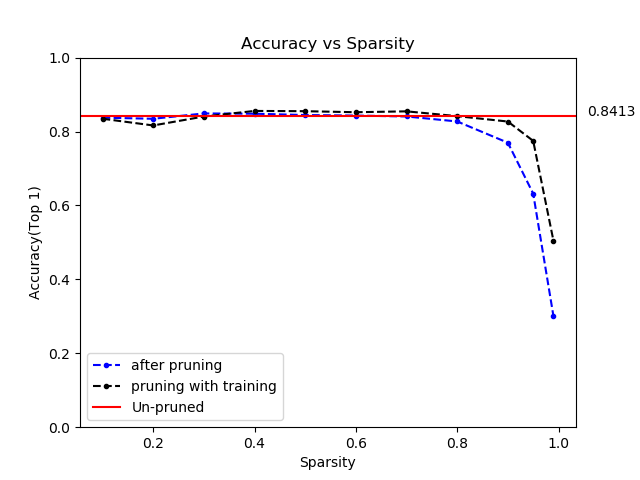

<IPython.core.display.Javascript object>


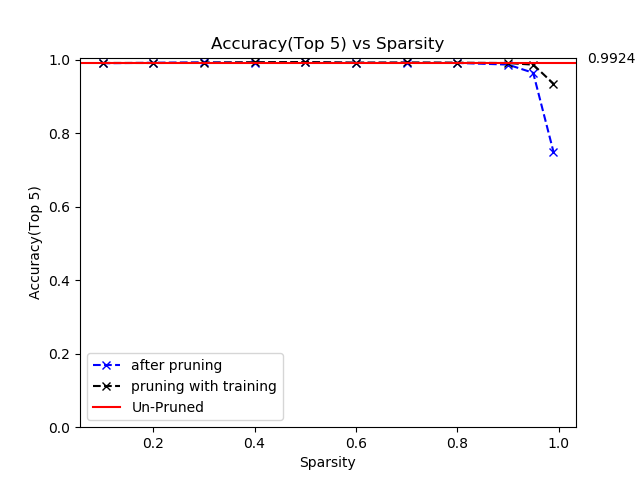

In [150]:
# Plotting the Trade-off between Accuracy and Sparsity
plt.figure()
plt.plot(sparsity, acc[0:55:5], 'b--.', label='after pruning')
plt.plot(sparsity, acc[4:55:5], 'k--.', label='pruning with training')
plt.axhline(y=acc_unpruned, color='r', linestyle='-', label = 'Un-pruned')
plt.annotate('{0:.4f}'.format(acc_unpruned), xy=(1, acc_unpruned), xytext=(8, 0), 
             xycoords=('axes fraction', 'data'), textcoords='offset points')
plt.title('Accuracy vs Sparsity')
plt.xlabel('Sparsity')
plt.ylabel('Accuracy(Top 1)')
plt.ylim(bottom=0, top=1) 
plt.legend(loc = 3)
plt.show()

plt.figure()
plt.plot(sparsity, acc_5[0:55:5], 'b--x', label='after pruning')
plt.plot(sparsity, acc_5[4:55:5], 'k--x', label='pruning with training')
plt.axhline(y=acc_unpruned_5, color='r', linestyle='-', label = 'Un-Pruned')
plt.annotate('{0:.4f}'.format(acc_unpruned_5), xy=(1, acc_unpruned_5), xytext=(8, 0), 
             xycoords=('axes fraction', 'data'), textcoords='offset points')
plt.title('Accuracy(Top 5) vs Sparsity')
plt.xlabel('Sparsity')
plt.ylabel('Accuracy(Top 5)')
plt.ylim(bottom=0) 
plt.legend(loc = 3)
plt.show()

In [131]:
thresh = [] 
pruned = []
not_pruned = []
weights_pruned = []
n_weights = []
with tf.Session() as sess:
    # Resets the session and restores the saved model
    sess.run(tf.global_variables_initializer())
    #saver.restore(sess, model_path_unpruned.format('best'))
    saver.restore(sess, model_path_pruned.format(0.8))
    # get the graph
    g = tf.get_default_graph()
    for i in range(7):
        if (i==0):
            t = g.get_tensor_by_name('Conv/threshold:0')
            m = g.get_tensor_by_name('Conv/mask:0')
            w = g.get_tensor_by_name('Conv/weights:0')

        else:
            t = g.get_tensor_by_name('Conv_{}/threshold:0'.format(i))
            m = g.get_tensor_by_name('Conv_{}/mask:0'.format(i))
            w = g.get_tensor_by_name('Conv_{}/weights:0'.format(i))
            
        x = sess.run(t)
        y = sess.run(m)
        z = sess.run(w)
        thresh.append(x)
        pruned.append(np.count_nonzero(y==0))
        not_pruned.append(np.sum(y))
        n_weights.append(np.size(y))
        weights_pruned.append(np.multiply(z,y))
        
print("Total Weights before Pruning: %.5fM" % (sum(n_weights) / 1e6))
print("Total Weights after Pruning: %.5fM" % (sum(not_pruned) / 1e6))
print("Total Weights pruned: %.5fM" % (sum(pruned) / 1e6))
print("Threshold for each layer:")
print(thresh)

INFO:tensorflow:Restoring parameters from Model_Saves/Pruned_0.8.ckpt
Total Weights before Pruning: 0.95376M
Total Weights after Pruning: 0.19118M
Total Weights pruned: 0.76258M
Threshold for each layer:
[0.10838378, 0.09941212, 0.11303033, 0.12204889, 0.122014865, 0.15555035, 0.189233]


<IPython.core.display.Javascript object>


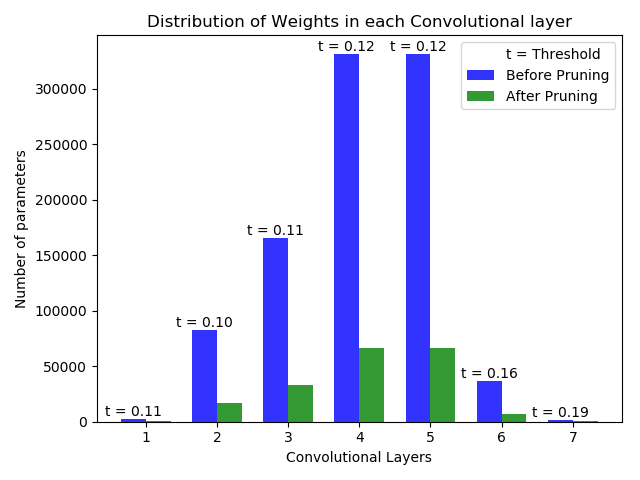

In [153]:
# data to plot
n_layers = 7
 
# create plot
fig, ax = plt.subplots()
index = np.arange(n_layers)
bar_width = 0.35
opacity = 0.8
 
rects1 = plt.bar(index, weights, bar_width,
alpha=opacity,
color='b',
label='Before Pruning')
 
rects2 = plt.bar(index + bar_width, not_pruned, bar_width,
alpha=opacity,
color='g',
label='After Pruning')

# Add counts above the two bar graphs
for i,rect in enumerate(rects1):
    height = rect.get_height()
    plt.text(rect.get_x() + rect.get_width()/2.0, height, 't = {0:.2f}'.format(thresh[i]),
             ha='center', va='bottom')

plt.xlabel('Convolutional Layers')
plt.ylabel('Number of parameters')
plt.title('Distribution of Weights in each Convolutional layer')
plt.xticks(index + bar_width/2, ('1', '2', '3', '4', '5', '6', '7'))
# Create empty plot with blank marker containing the extra legend
plt.plot([], [], ' ', label="t = Threshold")
plt.legend()
 
plt.tight_layout()
plt.show()

In [133]:
# Removing zeros from Pruned weights and flattening
weights_pruned_2 = []
for wei in weights_pruned:
    wei = wei[wei!=0]
    weights_pruned_2.extend(wei)

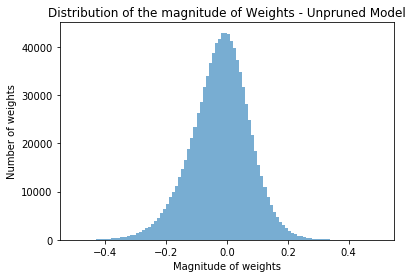

In [136]:
plt.figure()
n, bins, patches = plt.hist(weights_unpruned, 100, range = (-0.5,0.5), alpha=0.6)
plt.xlabel('Magnitude of weights')
plt.ylabel('Number of weights')
plt.title('Distribution of the magnitude of Weights - Unpruned Model')
plt.show()

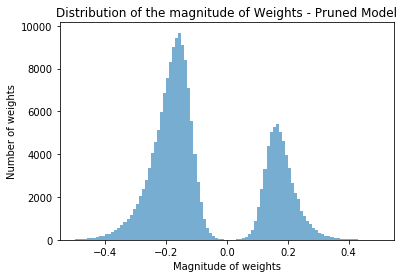

In [137]:
plt.figure()
n, bins, patches = plt.hist(weights_pruned_2, 100, range = (-0.5,0.5), alpha=0.6)
plt.xlabel('Magnitude of weights')
plt.ylabel('Number of weights')
plt.title('Distribution of the magnitude of Weights - Pruned Model')
plt.show()

In [138]:
# #Code snippet to print the number of training Parameters

# total_parameters = 0
# for variable in tf.trainable_variables():
#     shape = variable.get_shape()
#     variable_parametes = 1
#     for dim in shape:
#         variable_parametes *= dim.value
#     total_parameters += variable_parametes
# print("Total training params: %.5fM" % (total_parameters / 1e6))

# #Code snippet to print/load Weights as numpys
# with tf.Session() as sess:
#     # Resets the session and restores the saved model
#     sess.run(tf.global_variables_initializer())
#     saver.restore(sess, model_path_pruned.format(0.9))
#     tvars = tf.trainable_variables()
#     tvars_vals = sess.run(tvars)

#     for var, val in zip(tvars, tvars_vals):
#         print(var.name, val)

# #Code Snippet 2:
# with tf.Session() as sess:
#     tvars = tf.trainable_variables()
#     for var in tvars:
#         if var.name.endswith('weights:0'):
#             val = sess.run(var)
#             print(var.name, val)

# #Code Snippet 3:
# weights_unpruned = []
# with tf.Session() as sess:
#     # Resets the session and restores the saved model
#     sess.run(tf.global_variables_initializer())
#     saver.restore(sess, model_path_unpruned.format('best'))
#     tvars = tf.trainable_variables()
#     for var in tvars:
#         if var.name.endswith('weights:0'):
#             val = sess.run(var)
#             weights_unpruned.extend(val.flatten())
#             #print(var.name, val)